## Playground

In [1]:
!gpustat

n100.mcl.weizmann.ac.il  Sun Jun  5 18:30:06 2022  455.32.00
[0] Tesla V100-PCIE-16GB | 33'C,  15 % |  1315 / 16160 MB | yanivni(1311M)
[1] Tesla V100-PCIE-16GB | 29'C,   0 % |     0 / 16160 MB |
[2] Tesla V100-PCIE-16GB | 29'C,   0 % |     4 / 16160 MB |
[3] Tesla V100-PCIE-16GB | 28'C,   0 % |     0 / 16160 MB |


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from common_utils.notebook_utils import *

device=cuda:0


In [6]:
from torch.utils.data import DataLoader
from PIL import Image
import pytorch_lightning as pl

from common_utils.resize_right import resize
from datasets.cropset import CropSet
from diffusion.diffusion import Diffusion
from diffusion.sr_diffusion import SRDiffusion
from diffusion.diffusion_pyramid import DiffusionPyramid
from diffusion.diffusion_pyramid_sr import SRDiffusionPyramid
from diffusion.diffusion_utils import save_diffusion_sample
from models.zssr import ZSSRNet

### Load pyramid from checkpoints

In [10]:
path_to_checkpoints = r'/home/yanivni/data/remote_projects/single-image-diffusion/lightning_logs/pyramid/balloons.png/version_2/checkpoints'
diffusion_timesteps = 2000
image_name = 'balloons.png'
levels = 3
coarsest_size_ratio = 0.135
size_ratios = coarsest_size_ratio ** (1.0 / (levels - 1))

pyramid = GaussianSRDiffusionPyramid.load_from_checkpoint(path_to_checkpoints, 
                                                          f'./images/{image_name}', 
                                                          levels, 
                                                          size_ratios,
                                                          diffusion_timesteps)

In [ ]:
pyramid.sample()

## Experiment: Re-using SR resolution layer

In [7]:
path_to_checkpoints = r'/home/yanivni/data/remote_projects/single-image-diffusion/lightning_logs/pyramid/balloons.png/version_5/checkpoints'
image_name = 'balloons.png'
levels = 3
coarsest_size_ratio = 0.135
size_ratios = coarsest_size_ratio ** (1.0 / (levels - 1))

In [12]:
level0 = GaussianDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=0-step=99999.ckpt'), 
                                                model=ZSSRNet(), timesteps=1000).to(device='cuda:0')
level1 = SRDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=1-step=99999.ckpt'), 
                                          model=ZSSRNet(in_channels=6), timesteps=1000).to(device='cuda:0')
level2 = SRDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=2-step=99999.ckpt'), 
                                                model=ZSSRNet(in_channels=6), timesteps=1000).to(device='cuda:0')
level3 = SRDiffusion.load_from_checkpoint(os.path.join(path_to_checkpoints, 'level=3-step=99999.ckpt'), 
                                          model=ZSSRNet(in_channels=6), timesteps=1000).to(device='cuda:0')

In [9]:
def show_sample(sample):
    s = (sample.clamp(-1, 1) + 1) / 2
    s = (s * 255).type(torch.uint8).moveaxis(1, 3)
    s = s.cpu().numpy()
    
    grid_size = int(len(s) ** 0.5)
    if grid_size > 1:
        f, axarr = plt.subplots(grid_size, grid_size)
        for idx, img in enumerate(s):
            axarr[idx // grid_size, idx % grid_size].imshow(img)
    else:
        plt.imshow(s[0])
        
    plt.show()

### Attempt: Sample using corresponding resolution layers

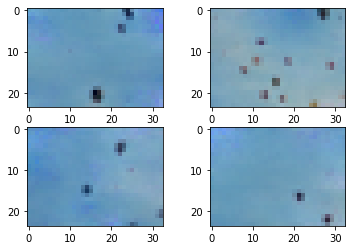

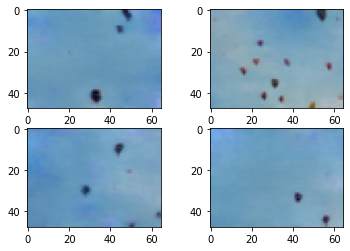

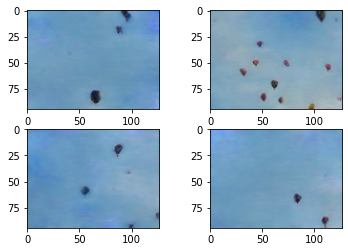

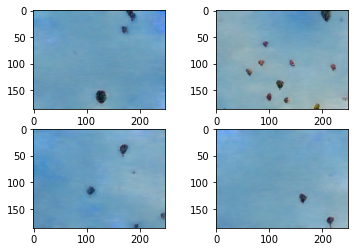

In [14]:
sizes = [(24, 33), (48, 65), (95, 127), (186, 248)]

s0 = level0.sample(image_size=sizes[0], batch_size=4)
s0_r = resize(s0, out_shape=sizes[1])

s1 = level1.sample(s0_r, image_size=sizes[1])
s1_r = resize(s1, out_shape=sizes[2])

s2 = level2.sample(s1_r, image_size=sizes[2])
s2_r = resize(s2, out_shape=sizes[3])

s3 = level3.sample(s2_r, image_size=sizes[3])

show_sample(s0)
show_sample(s1)
show_sample(s2)
show_sample(s3)

### Attempt: Sample using layer0 and layer1

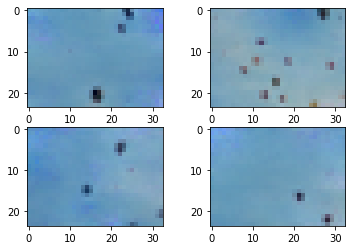

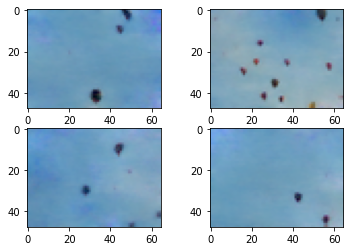

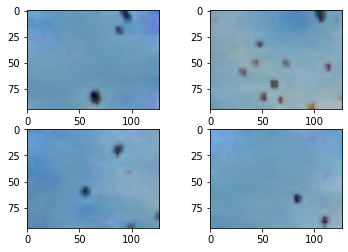

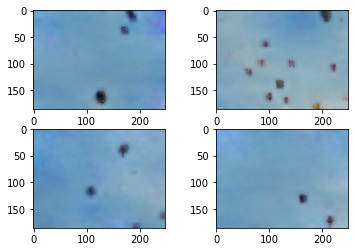

In [15]:
# Same s0 and s0_r

s1 = level1.sample(s0_r, image_size=sizes[1])
s1_r = resize(s0, out_shape=sizes[2])

s2 = level1.sample(s1_r, image_size=sizes[2])
s2_r = resize(s2, out_shape=sizes[3])

s3 = level1.sample(s2_r, image_size=sizes[3])

show_sample(s0)
show_sample(s1)
show_sample(s2)
show_sample(s3)

### Attempt: Sample using layer0 and layer2

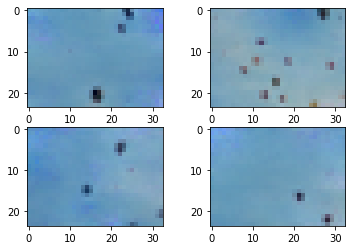

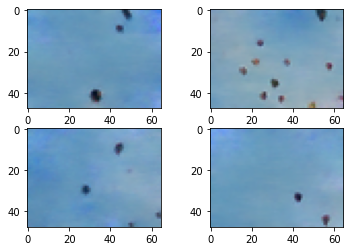

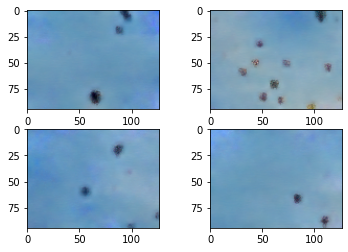

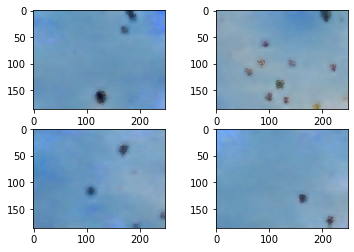

In [16]:
# Same s0 and s0_r

s1 = level2.sample(s0_r, image_size=sizes[1])
s1_r = resize(s0, out_shape=sizes[2])

s2 = level2.sample(s1_r, image_size=sizes[2])
s2_r = resize(s2, out_shape=sizes[3])

s3 = level2.sample(s2_r, image_size=sizes[3])

show_sample(s0)
show_sample(s1)
show_sample(s2)
show_sample(s3)